In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.metrics import accuracy_score
from collections import Counter
from wordcloud import WordCloud,STOPWORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip


In [2]:
train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
train.head()
test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
sample_submission = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')

test.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [3]:
def instance_per_category(data):
    data_categories = data.drop(['id','comment_text'],axis=1)
    count_toxic = Counter(data_categories['toxic'])
    count_severe = Counter(data_categories['severe_toxic'])
    count_obscene = Counter(data_categories['obscene'])
    count_threat = Counter(data_categories['threat'])
    count_insult = Counter(data_categories['insult'])
    count_iden = Counter(data_categories['identity_hate'])
    df = pd.DataFrame.from_dict([count_toxic,count_severe,count_obscene,count_threat,count_insult,count_iden])
    df.index  = ['toxic','severe toxic','obscene','threat','insult','identity hate']
    return df.T

print('total samples: {0}'.format(train.shape[0]))
train_categories = instance_per_category(train)
train_categories

total samples: 159571


,toxic,severe toxic,obscene,threat,insult,identity hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


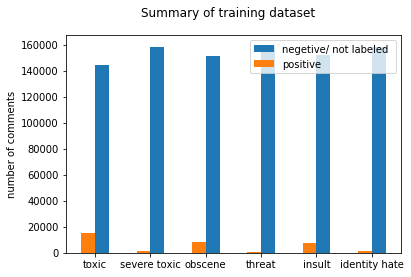

In [4]:
def plot_category(data):
    x = np.arange(len(data.columns))
    labels = list(data.columns)
    width = 0.25
    fig,ax = plt.subplots()
    fig.suptitle('Summary of training dataset')
    ax1= ax.bar(x = x+ width/2,  height = data.iloc[0,:], width = width, label='negetive/ not labeled ')
    ax2 = ax.bar(x = x- width/2,  height = data.iloc[1,:], width = width, label= 'positive')
    ax.set_ylabel('number of comments')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()


plot_category(train_categories)

This plot below shows that this dataset contains comments which can be categorized into more than one categories. Moreover, this dataset contains large amount of unlabelled data.

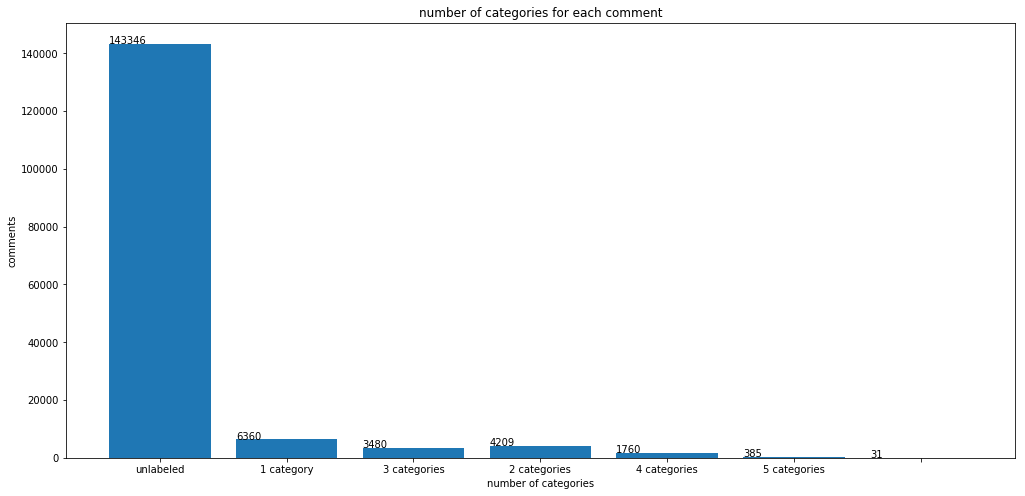

In [5]:
def multi_label(data):
    sum_ = data.iloc[:,2:].sum(axis=1)
    x = sum_.value_counts()
    fig = plt.figure(figsize = (17,8))
    ax = plt.bar(x.index,x.values )
    for bar in ax:
        bar_h = bar.get_height()
        plt.text(bar.get_x(), bar_h, bar_h)       
    plt.xticks(x.index,['unlabeled','1 category','2 categories','3 categories','4 categories','5 categories'])
    plt.title('number of categories for each comment')
    plt.xlabel('number of categories')
    plt.ylabel('comments')
    plt.show()
    
multi_label(train)

In [6]:
print('total unlabelled data: {0}'.format( sum( (train.iloc[:,2] == 0) & (train.iloc[:,3] == 0) & (train.iloc[:,4] == 0) &(train.iloc[:,5] == 0) & (train.iloc[:,6] == 0) & (train.iloc[:,7] == 0))))


total unlabelled data: 143346


In [7]:
print('number of missing comments: {0}'.format(train.iloc[:,1].isnull().sum()))

number of missing comments: 0


In [8]:
def text_cleaning(text: str)-> str:
    text = text.lower()
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"\n" , " ", text)
    text = re.sub(r"\'d'", " ", text)
    text = re.sub(r"\'s'" , " ", text)
    text = re.sub(r"\'ll", " ", text)
    text = re.sub(r"\'m'", " ", text)
    text = re.sub(r"\'re'", " ", text)
    return text
    
train['comment_text'] = train['comment_text'].map( lambda text : text_cleaning(str(text)))
test['comment_text'] = test['comment_text'].map( lambda text : text_cleaning(str(text)))

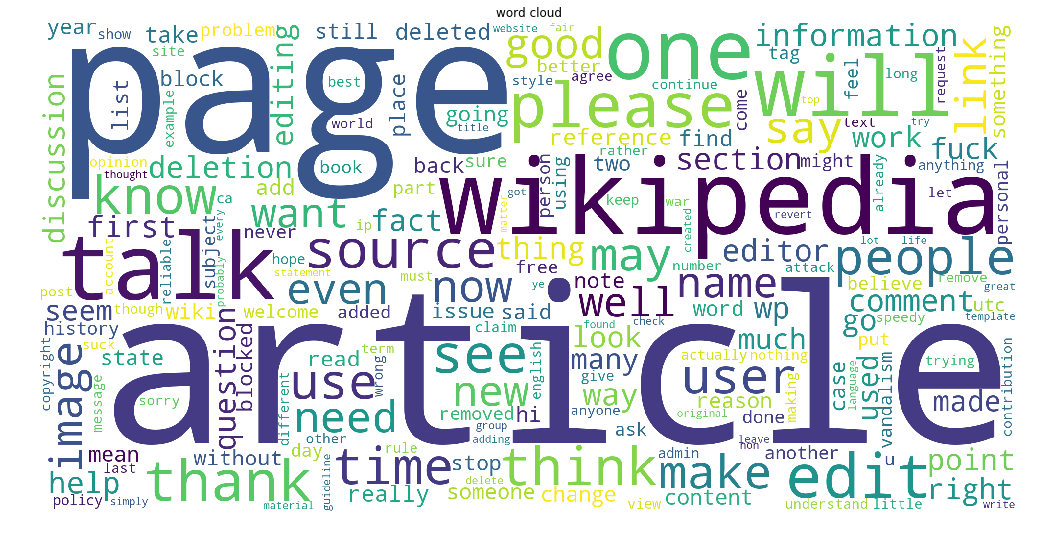

In [9]:
def word_cloud(text):
    plt.figure(figsize=(20,9))
    texts = text.values
    cloud = WordCloud(stopwords=STOPWORDS, background_color = 'white', collocations = False, width=2000, height= 1000).generate(" ".join(text))
    plt.axis('off')
    plt.title('word cloud')
    plt.imshow(cloud)
word_cloud(train['comment_text'])

 frequency of the length of the comments


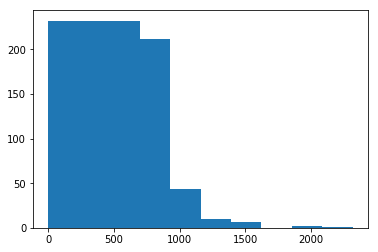

In [10]:
def comment_length(data):
    comments = data.iloc[:,1]
    length_comments = [len (comment.split(' ')) for comment in comments]
    max_len = max(length_comments)
    min_len = min(length_comments)
    count = Counter(length_comments)
    print(" frequency of the length of the comments")
    plt.hist(list(count))
    return count
comment_lengths = comment_length(train)

most of the comments have length between 0 to 1000 with few outliers.

In [11]:
def tokenize(text):
    tokens = word_tokenize(text)
    tokens_alpha = [token for token in tokens if token.isalpha()]
    return tokens_alpha

train['comment_text'] = train['comment_text'].map(lambda text: tokenize(text))
test['comment_text'] = test['comment_text'].map(lambda text: tokenize(text))

In [12]:
train_set,test_set = train_test_split(train,random_state=42,test_size=0.3,shuffle=True)
x_train = train_set['comment_text'].values
y_train= train_set.iloc[:,2:]

x_test = test_set['comment_text'].values
y_test = test_set.iloc[:,2:]

In [13]:
vectorizer = TfidfVectorizer(max_features=1500)
x_train = vectorizer.fit_transform(str(x) for x in x_train)
x_test = vectorizer.transform(str(x) for x in x_test)
sub_x = vectorizer.transform(str(x) for x in test['comment_text'].values)

In [14]:
classifier = ClassifierChain(MultinomialNB(fit_prior=True))
classifier.fit(x_train,y_train)
y_predict = classifier.predict(x_test)
score = accuracy_score(y_test,y_predict)
print('estimated accuracy score: {0}'.format(score))

ClassifierChain(classifier=MultinomialNB(alpha=1.0, class_prior=None,
                                         fit_prior=True),
                order=None, require_dense=[True, True])

estimated accuracy score: 0.8995446189839572


In [15]:
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [16]:
test_predict = classifier.predict_proba(sub_x)
test_predict= test_predict.todense()

In [17]:
ids = pd.DataFrame(test['id'])
predict = pd.DataFrame(test_predict,columns= ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.concat([ids, predict] ,axis = 1)
submission.to_csv('submission.csv',index=False)